<a href="https://colab.research.google.com/github/antcc/proyecto-vc/blob/master/yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### *Fuente: https://github.com/antcc/proyecto-vc*
# Detección de caras con YOLOv3
Utilizaremos la base de datos [WIDERFACE](http://shuoyang1213.me/WIDERFACE/).

## Preliminares
Montamos nuestro *drive* y establecemos el directorio de trabajo. Debemos tener los siguientes archivos disponibles en el mismo:

* Una carpeta **yolo** con los ficheros de código disponibles en el repositorio, respetando la estructura presente en el mismo.
* Una carpeta llamada **data** que contenga a su vez 4 subcarpetas:
  * **train**: contiene las imágenes de entrenamiento.
  * **train_annot**: contiene las anotaciones de las imágenes de entrenamiento en formato VOC.
  * **valid**: contiene las imágenes de validación.
  * **valid_annot**: contiene las anotaciones de las imágenes de validación en formato VOC.
* Un archivo *config.json* que defina el entorno de configuración, similar al disponible en el respositorio.
* Una carpeta **models** donde se guardarán los modelos entrenados. Debe contener inicialmente un archivo *backend.h5* con pesos preentrenados en la red concreta que se ha implementado. Por ejemplo, unos pesos preentrenados en la base de datos COCO pueden obtenerse [aquí](https://s3-ap-southeast-1.amazonaws.com/deeplearning-mat/backend.h5).

Durante el entrenamiento se crearán automáticamente archivos auxiliares en el directorio de trabajo.

*Nota:* las anotaciones en formato VOC pueden obtenerse a partir de las originales empleando el script `yolo/utils/convert_annot.py`.





In [0]:
%tensorflow_version 1.x
import sys 
import os
import json
from google.colab import drive

# Directorio de trabajo
drive.mount("/content/drive", force_remount = True)
DIR = "/content/drive/My Drive/vc/" 
sys.path.append(os.path.abspath(DIR))
model_loaded = False

# Archivo de configuración
config_path = DIR + "config.json"
with open(config_path) as config_buffer:
    config = json.loads(config_buffer.read())

## Entrenamiento
Creamos un modelo de la red YOLOv3, que entrenamos con los datos de entrenamiento. En el archivo de configuración, los parámetros de entrenamiento más destacables son:

* *min_input_size* y *max_input_size*: controlan el rango en el que serán redimensionadas las imágenes de entrenamiento. Deben ser múltiplos de 32.
* *input_size*: controla el tamaño de entrada de las imágenes de validación. Debe ser múltiplo de 32.
* *batch_size* y *learning_rate*: Tamaño de cada *batch* y *learning rate* inicial del optimizador Adam.
* *nb_epochs* y *warmup_epochs*: establecen el número de épocas de entrenamiento normales y el número de épocas de entrenamiento iniciales en las que se fuerza a que las *boxes* coincidan con los *anchors*. En total se entranará durante un número de épocas igual a la suma de estos parámetros.
* *saved_weights_name*: indica la ruta en la que se guardará el modelo entrenado en formato HDF5.

Disponemos de un *callback* de *early stopping* que detiene el entrenamiento si la función de pérdida no mejora en 10 épocas. También tenemos otro *callback* que reduce el *learning rate* en un orden de magnitud si la pérdida no mejora en 3 épocas.

El archivo con el modelo entrenado puede usarse para renaudar el entrenamiento (cargándolo con `load_weights`) o para realizar predicciones (cargándolo con `load_model`). 

In [0]:
import pickle
from keras.models import load_model
from yolo.train import create_training_instances, create_model, create_callbacks
from yolo.generator import BatchGenerator
from yolo.utils.utils import normalize

def _train(epochs, early_stop = False):
    ###############################
    #   Leemos anotaciones
    ###############################
    train_ints, _, labels, max_box_per_image = create_training_instances(
        config['train']['train_annot_folder'],
        config['train']['train_image_folder'],
        config['train']['cache_name'],
        config['valid']['valid_annot_folder'],
        config['valid']['valid_image_folder'],
        config['valid']['cache_name'],
        config['model']['labels']
    )
    print('\nTraining on: \t' + str(labels) + '\n')

    ##################################
    #   Creamos generador de imágenes
    ##################################
    train_generator = BatchGenerator(
        instances           = train_ints,
        anchors             = config['model']['anchors'],
        labels              = labels,
        downsample          = 32, # ratio between network input's size and network output's size, 32 for YOLOv3
        max_box_per_image   = max_box_per_image,
        batch_size          = config['train']['batch_size'],
        min_net_size        = config['model']['min_input_size'],
        max_net_size        = config['model']['max_input_size'],
        shuffle             = True,
        jitter              = 0.3,
        norm                = normalize
    )

    ###############################
    #   Creamos el modelo
    ###############################
    if os.path.exists(config['train']['saved_weights_name']):
        config['train']['warmup_epochs'] = 0
    warmup_batches = config['train']['warmup_epochs'] * (config['train']['train_times']*len(train_generator))

    os.environ['CUDA_VISIBLE_DEVICES'] = config['train']['gpus']
    multi_gpu = len(config['train']['gpus'].split(','))

    train_model, infer_model = create_model(
        nb_class            = len(labels),
        anchors             = config['model']['anchors'],
        max_box_per_image   = max_box_per_image,
        max_grid            = [config['model']['max_input_size'], config['model']['max_input_size']],
        batch_size          = config['train']['batch_size'],
        warmup_batches      = warmup_batches,
        ignore_thresh       = config['train']['ignore_thresh'],
        multi_gpu           = multi_gpu,
        saved_weights_name  = config['train']['saved_weights_name'],
        lr                  = config['train']['learning_rate'],
        grid_scales         = config['train']['grid_scales'],
        obj_scale           = config['train']['obj_scale'],
        noobj_scale         = config['train']['noobj_scale'],
        xywh_scale          = config['train']['xywh_scale'],
        class_scale         = config['train']['class_scale'],
        backend_path        = DIR + "models/backend.h5"
    )

    ################################
    #   Comenzamos el entrenamiento
    ################################
    callbacks = create_callbacks(config['train']['saved_weights_name'], config['train']['tensorboard_dir'], infer_model)

    if not early_stop:
      callbacks = callbacks[1:]

    hist = train_model.fit_generator(
        generator        = train_generator,
        steps_per_epoch  = len(train_generator) * config['train']['train_times'],
        epochs           = epochs + config['train']['warmup_epochs'],
        verbose          = 2 if config['train']['debug'] else 1,
        callbacks        = callbacks,
        workers          = 4,
        max_queue_size   = 8
    )

    model_loaded = False

    print("\nTraining completed. Saved training history.")
    with open(config['train']['tensorboard_dir'] + "train_hist", 'wb') as f:
        pickle.dump(hist, f)

## Evaluación

Evaluamos el modelo obtenido en el conjunto de validación. La métrica de evaluación utilizada es la precisión media o *mAP* tal y como se evalúa en el *COCO Challenge* desde 2017. La media se toma variando en 10 umbrales distintos de IoU: 0.5, 0.6, 0.65, ..., 0.95. Tras finalizar, se guardan las *bounding boxes* detectadas para cada imagen en el archivo definido en la variable *valid_result* del archivo de configuración. Se utiliza el formato definido [aquí](https://competitions.codalab.org/competitions/20146#learn_the_details-overview). Es posible crear únicamente el archivo de *valid_result* sin calcular las métricas de precisión.

También se proporciona una función para detectar caras en una imagen concreta, mostrando gráficamente el resultado.

In [0]:
from yolo.evaluate import evaluate_coco, predict_boxes
from yolo.utils.bbox import draw_boxes
from yolo.utils.utils import get_yolo_boxes
from yolo.generator import BatchGenerator
from yolo.voc import parse_voc_annotation
from yolo.utils.utils import normalize
from keras.models import load_model
import cv2
import matplotlib.pyplot as plt

def _evaluate(model, calculate_ap = False):
    # Leemos las anotaciones
    valid_ints, labels = parse_voc_annotation(
        config['valid']['valid_annot_folder'],
        config['valid']['valid_image_folder'],
        config['valid']['cache_name'],
        config['model']['labels']
    )

    labels = labels.keys() if len(config['model']['labels']) == 0 else config['model']['labels']
    labels = sorted(labels)

    # Creamos el generador de imágenes de validación
    valid_generator = BatchGenerator(
        instances           = valid_ints,
        anchors             = config['model']['anchors'],
        labels              = labels,
        downsample          = 32,
        max_box_per_image   = 0,
        batch_size          = config['train']['batch_size'],
        min_net_size        = config['model']['min_input_size'],
        max_net_size        = config['model']['max_input_size'],
        shuffle             = True,
        jitter              = 0.0,
        norm                = normalize
    )

    # Realizamos predicciones y guardamos resultados en fichero
    detections, annotations = predict_boxes(
        model,
        valid_generator,
        obj_thresh = 0.5,
        nms_thresh = 0.5,
        net_h=config['model']['input_size'],
        net_w=config['model']['input_size'],
        save_path = config['valid']['valid_result'])

    if calculate_ap:
        # Calculamos la métrica mAP
        average_precision = evaluate_coco(
            model,
            valid_generator,
            detections,
            annotations)[0]

        # Imprimimos el resultado
        print('mAP: {:.4f}'.format(average_precision))

def _detect(model, filename):
    # Leemos la imagen
    im = cv2.cvtColor(cv2.imread(filename, 1), cv2.COLOR_BGR2RGB)

    # Predecimos las bounding boxes     
    pred_boxes = get_yolo_boxes(
        model, 
        images = [im],
        net_h = config['model']['input_size'], 
        net_w = config['model']['input_size'], 
        anchors = config['model']['anchors'],
        obj_thresh = 0.5, 
        nms_thresh = 0.5)[0]
  
    # Mostramos la imagen con los resultados
    im_boxes = draw_boxes(im, pred_boxes)
    plt.figure(figsize = (8, 8))
    plt.imshow(im_boxes)
    plt.show()

## Prueba de funcionamiento

Probamos ahora a entrenar y evaluar el modelo. También pintamos una imagen del conjunto de validación para visualizar las caras detectadas.

In [0]:
# Definimos los parámetros de entrenamiento
EARLY_STOP = False
EPOCHS = config['train']['nb_epochs']

# Entrenamos el modelo
_train(EPOCHS, EARLY_STOP)

In [0]:
# Cargamos el modelo
if not model_loaded:
    yolov3 = load_model(config['train']['saved_weights_name'])
    model_loaded = True

# Evaluamos el modelo
_evaluate(yolov3)

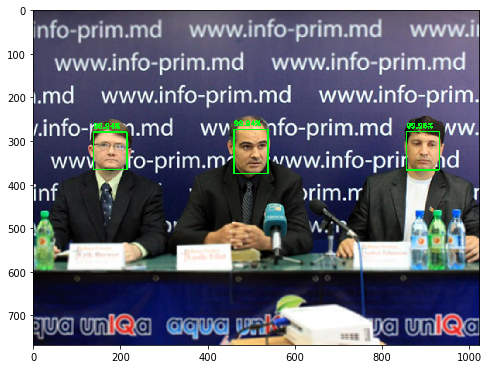

In [5]:
# Cargamos el modelo
if not model_loaded:
    yolov3 = load_model(config['train']['saved_weights_name'])
    model_loaded = True

# Definimos una imagen de prueba
filename = DIR + "data/valid/9--Press_Conference/9_Press_Conference_Press_Conference_9_74.jpg"

# Detectamos caras en la imagen de prueba
_detect(yolov3, filename)